# Determine the best features using a Logistic Regression Model

## Imports

In [ ]:
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from collections import defaultdict


from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    accuracy_score,
)
from sklearn.model_selection import train_test_split
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from joblib import dump, load

## Find the git root Directory

In [ ]:
# Get the current working directory
cwd = Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd

else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break

# Check if a Git root directory was found
if root_dir is None:
    raise FileNotFoundError("No Git root directory found.")

## Import Utils

In [ ]:
sys.path.append(f"{root_dir}/utils")
import analysis_utils as au
import preprocess_utils as ppu
import eval_utils as eu
import train_utils as tu

# Seed and Generator for Reproducibility

In [ ]:
rnd_val = 0  # Random value for all seeds
rng = np.random.default_rng(seed=rnd_val)  # random number generator

## Create output paths if they don't exist

In [ ]:
fig_out_path = Path("feature_importance_figures")
data_path = Path("data")

if not fig_out_path.exists():
    fig_out_path.mkdir()

if not data_path.exists():
    data_path.mkdir()

## Read the calculated dataframes

In [ ]:
pos_genes = ["HET", "Null", "WT"]
featdf = pd.read_csv(data_path / "feature_weights.tsv", delimiter="\t")
totfeatimp = pd.read_csv(data_path / "overall_feature_importances.tsv", delimiter="\t")
featimp = pd.read_csv(data_path / "avg_norm_feature_importances.tsv", delimiter="\t")

## Plot the most important HET features

Installed tk event loop hook.


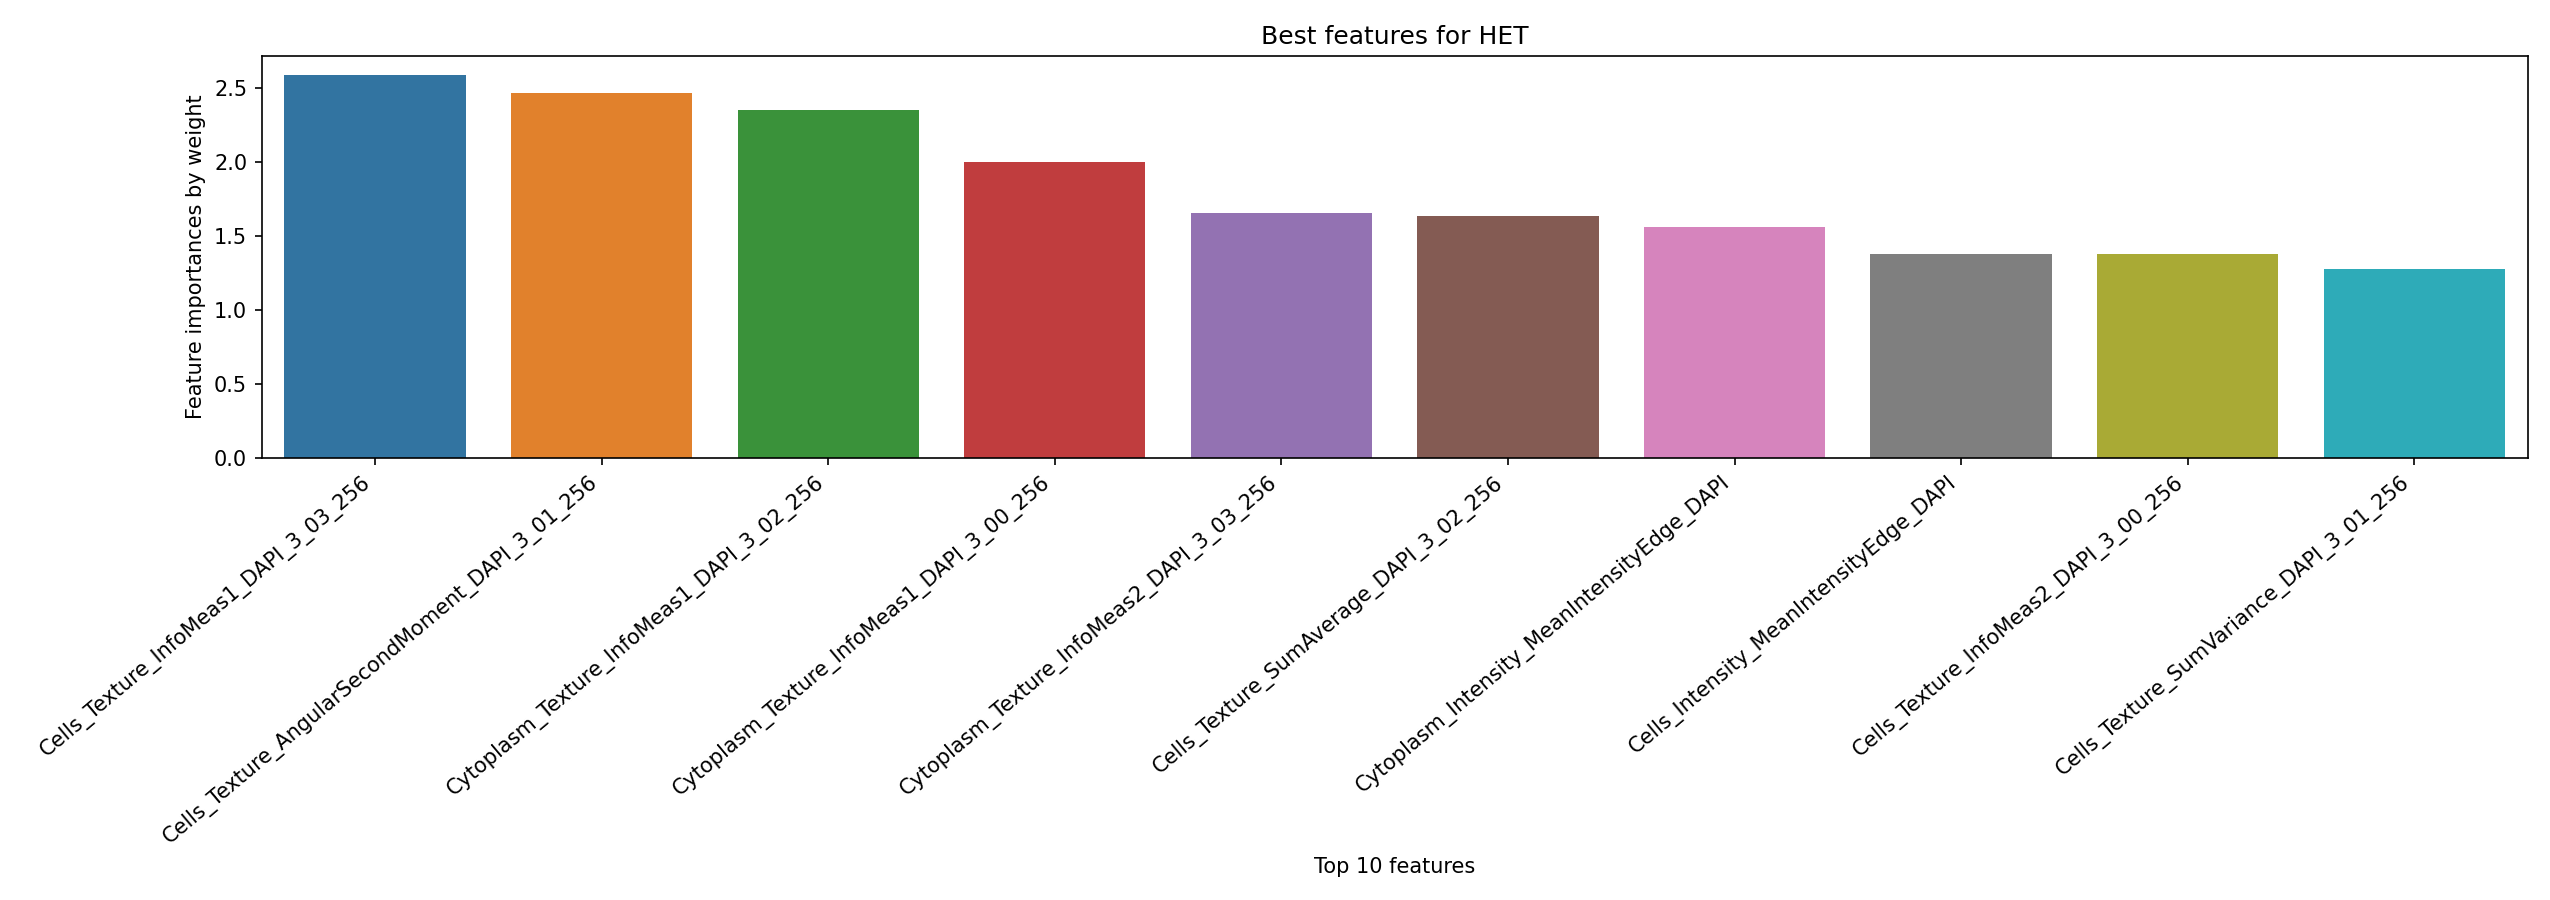

In [1]:
featdf["abs_HET"] = featdf["HET"].abs()
featdf = featdf.sort_values("abs_HET", ascending=False)

disp_feat = 10
gtype = "HET"

feat_imp = featdf["abs_HET"][:disp_feat]
col_names = featdf["features"][:disp_feat]
plt.figure(figsize=(17, 6))
ax = sns.barplot(x=np.arange(disp_feat), y=feat_imp)
ax.set_xticklabels(col_names, rotation=40, ha="right")
plt.ylabel("Feature importances by weight")
plt.xlabel(f"Top {disp_feat} features")
plt.title(f"Best features for {gtype}")
plt.tight_layout()
plt.savefig(f"{fig_out_path}/{gtype}_feature_importances_by_weight")

## Plot the average feature importances for each genotype

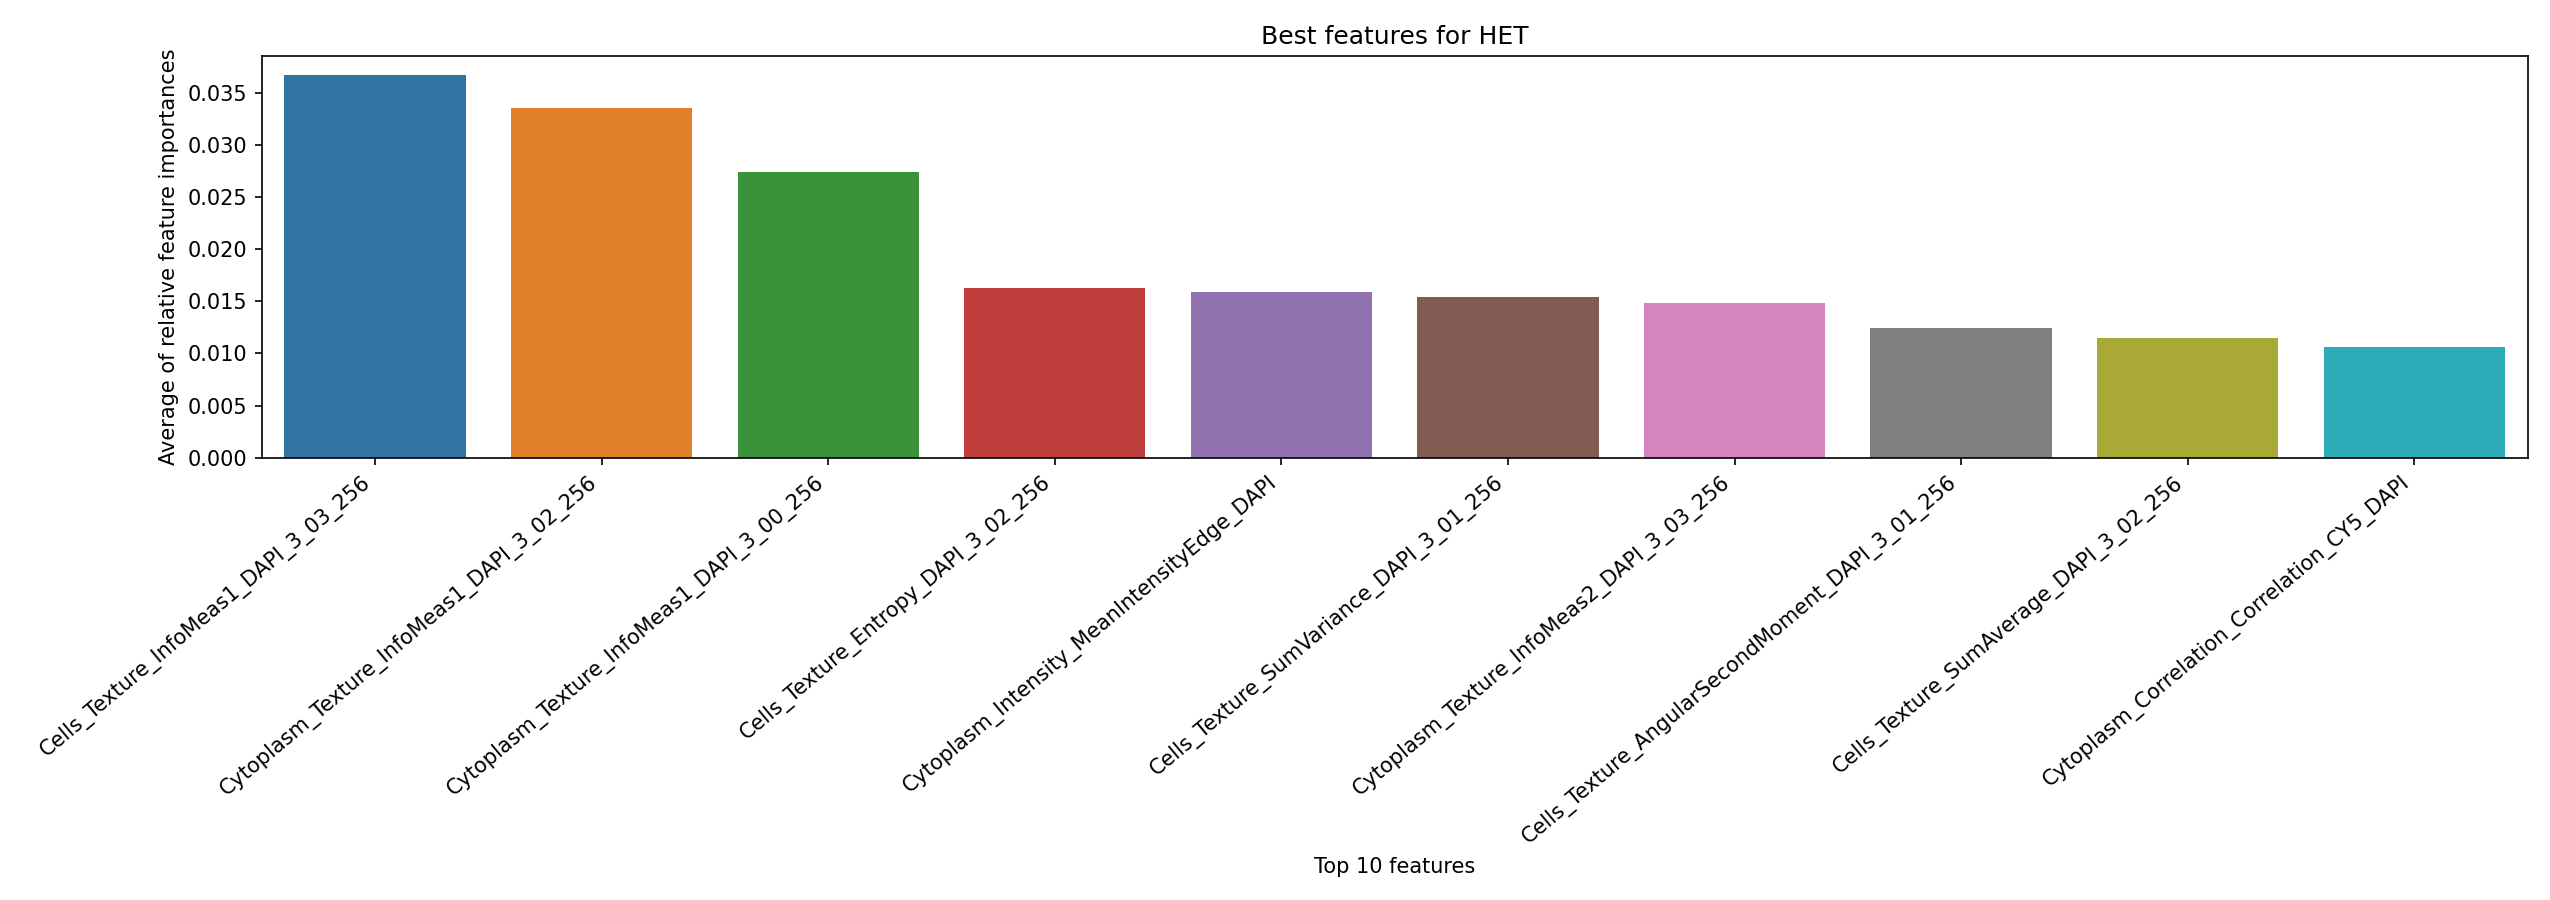

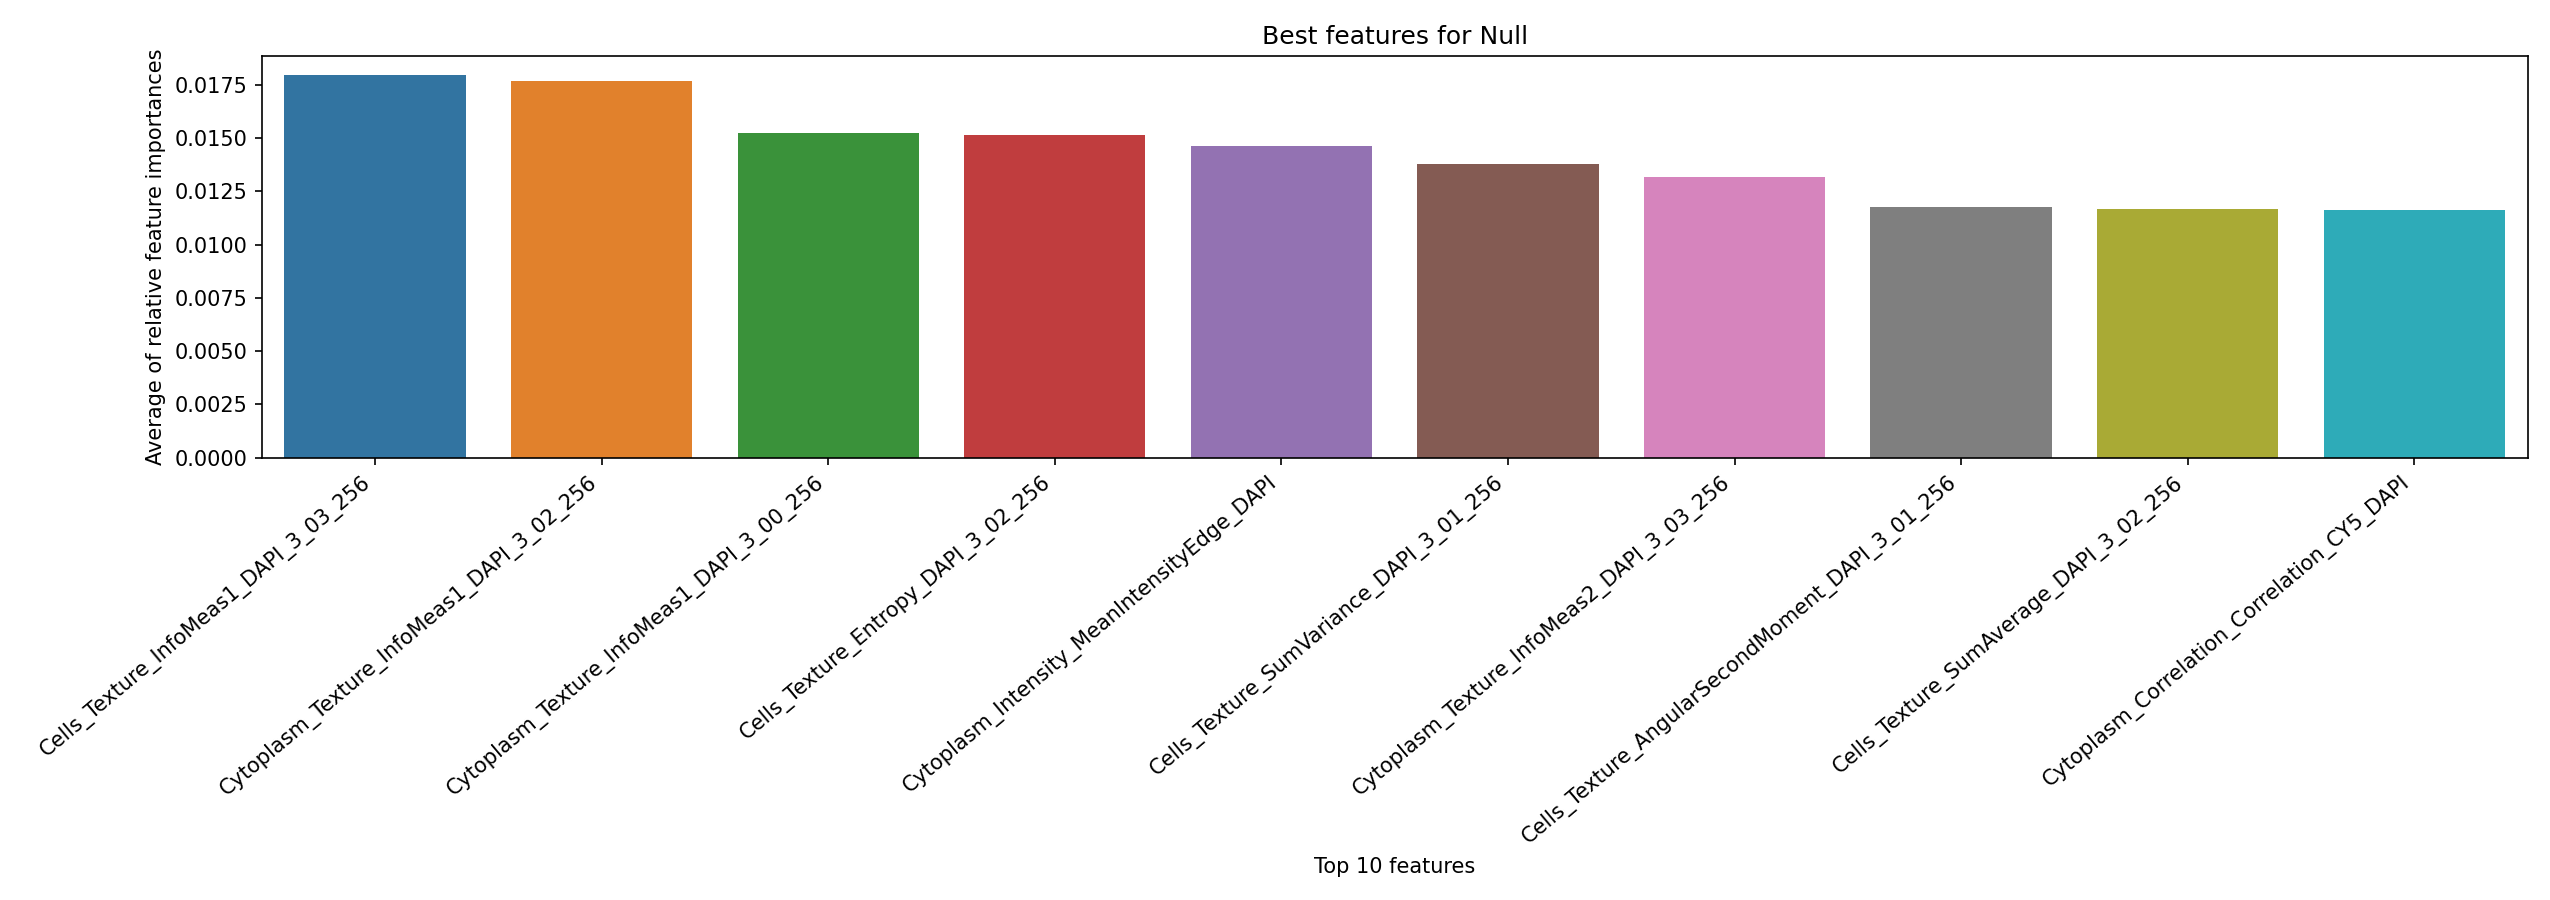

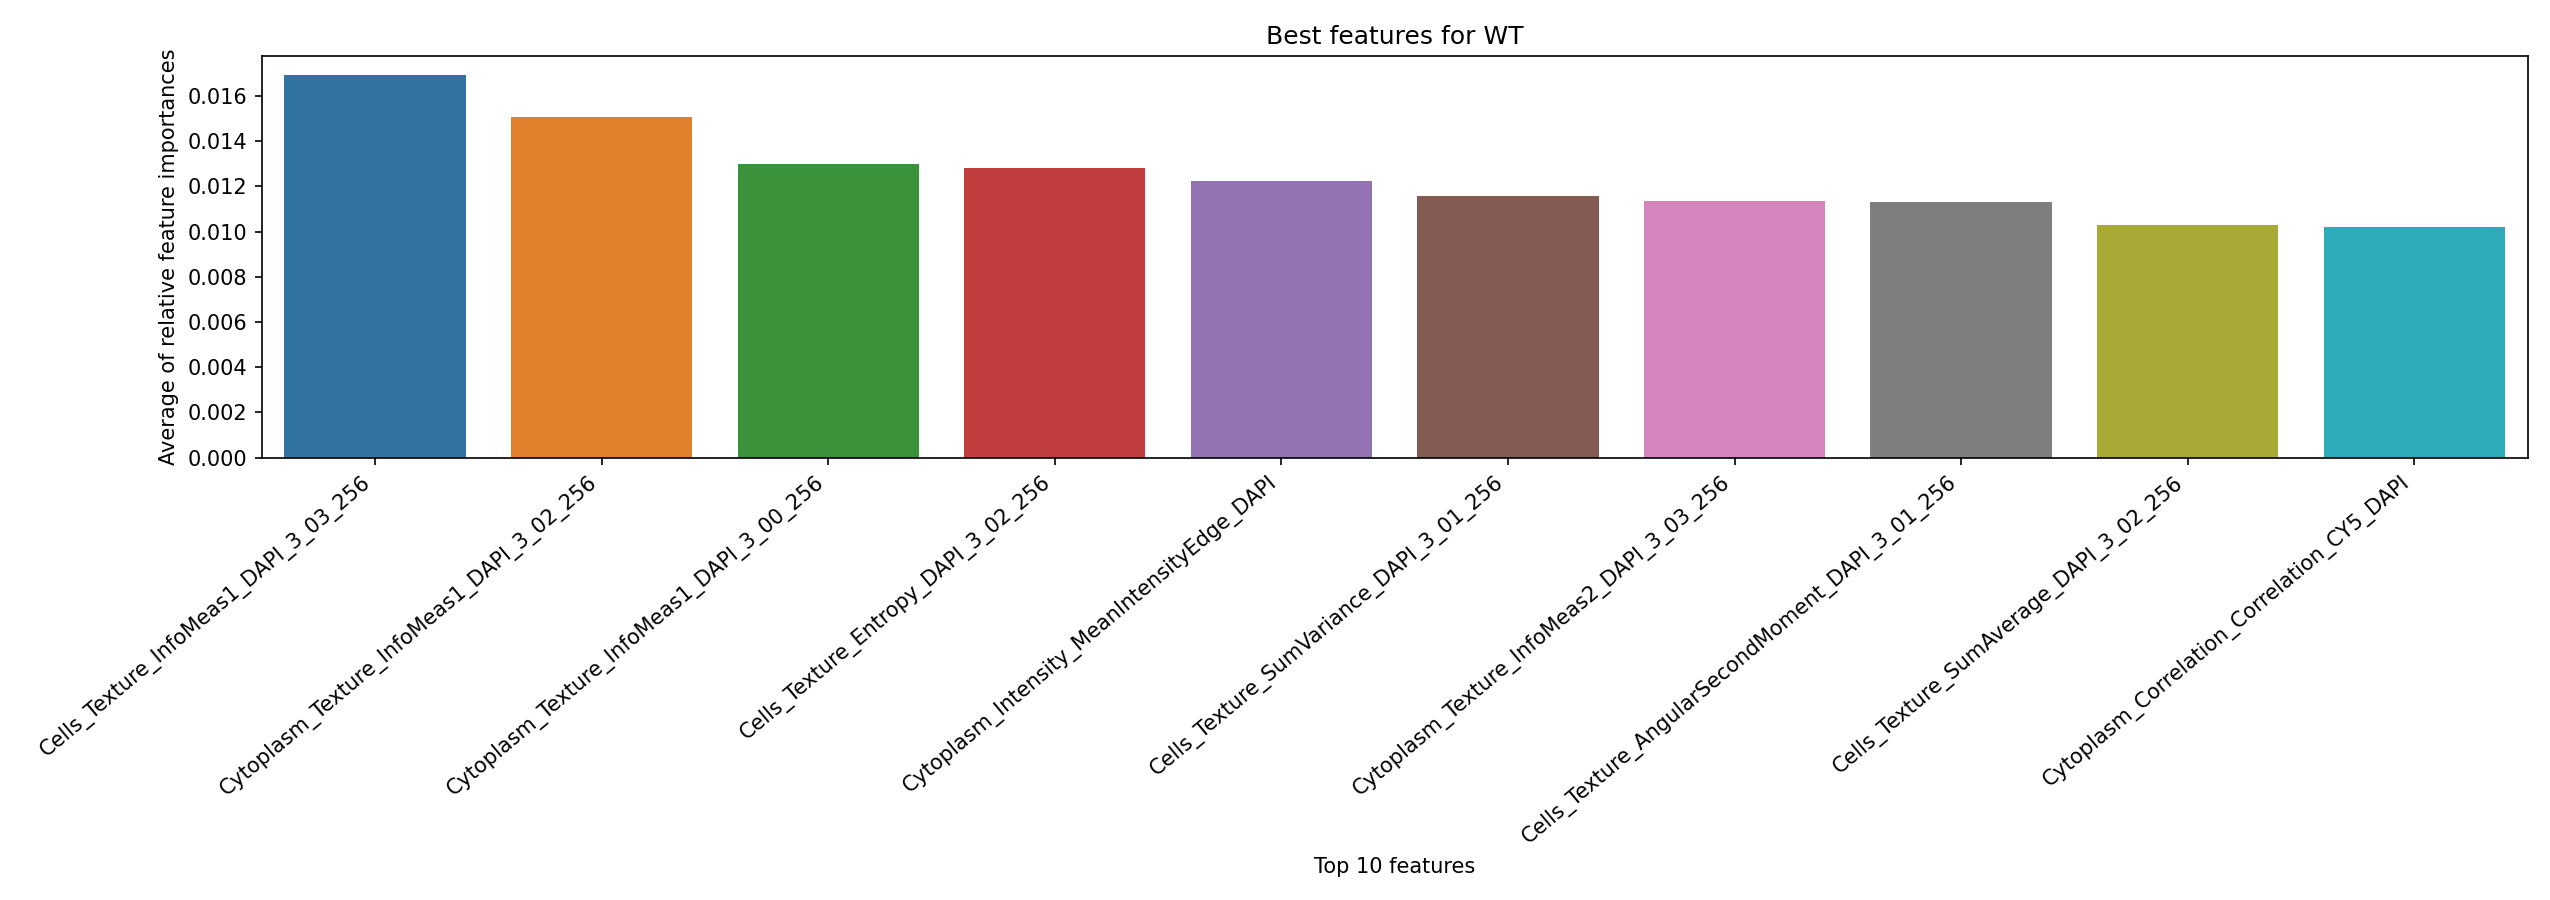

In [2]:
for genotype in pos_genes:
    feat_imp = featimp.sort_values(genotype, ascending=False)[genotype][:disp_feat]
    col_names = featimp["Features"][:disp_feat]
    plt.figure(figsize=(17, 6))
    ax = sns.barplot(x=np.arange(disp_feat), y=feat_imp)
    ax.set_xticklabels(col_names, rotation=40, ha="right")
    plt.ylabel("Average of relative feature importances")
    plt.xlabel(f"Top {disp_feat} features")
    plt.title(f"Best features for {genotype}")
    plt.tight_layout()
    plt.savefig(f"{fig_out_path}/{genotype}_average_feature_importances.png")

## Plot the top aggregate and genotype feature importances

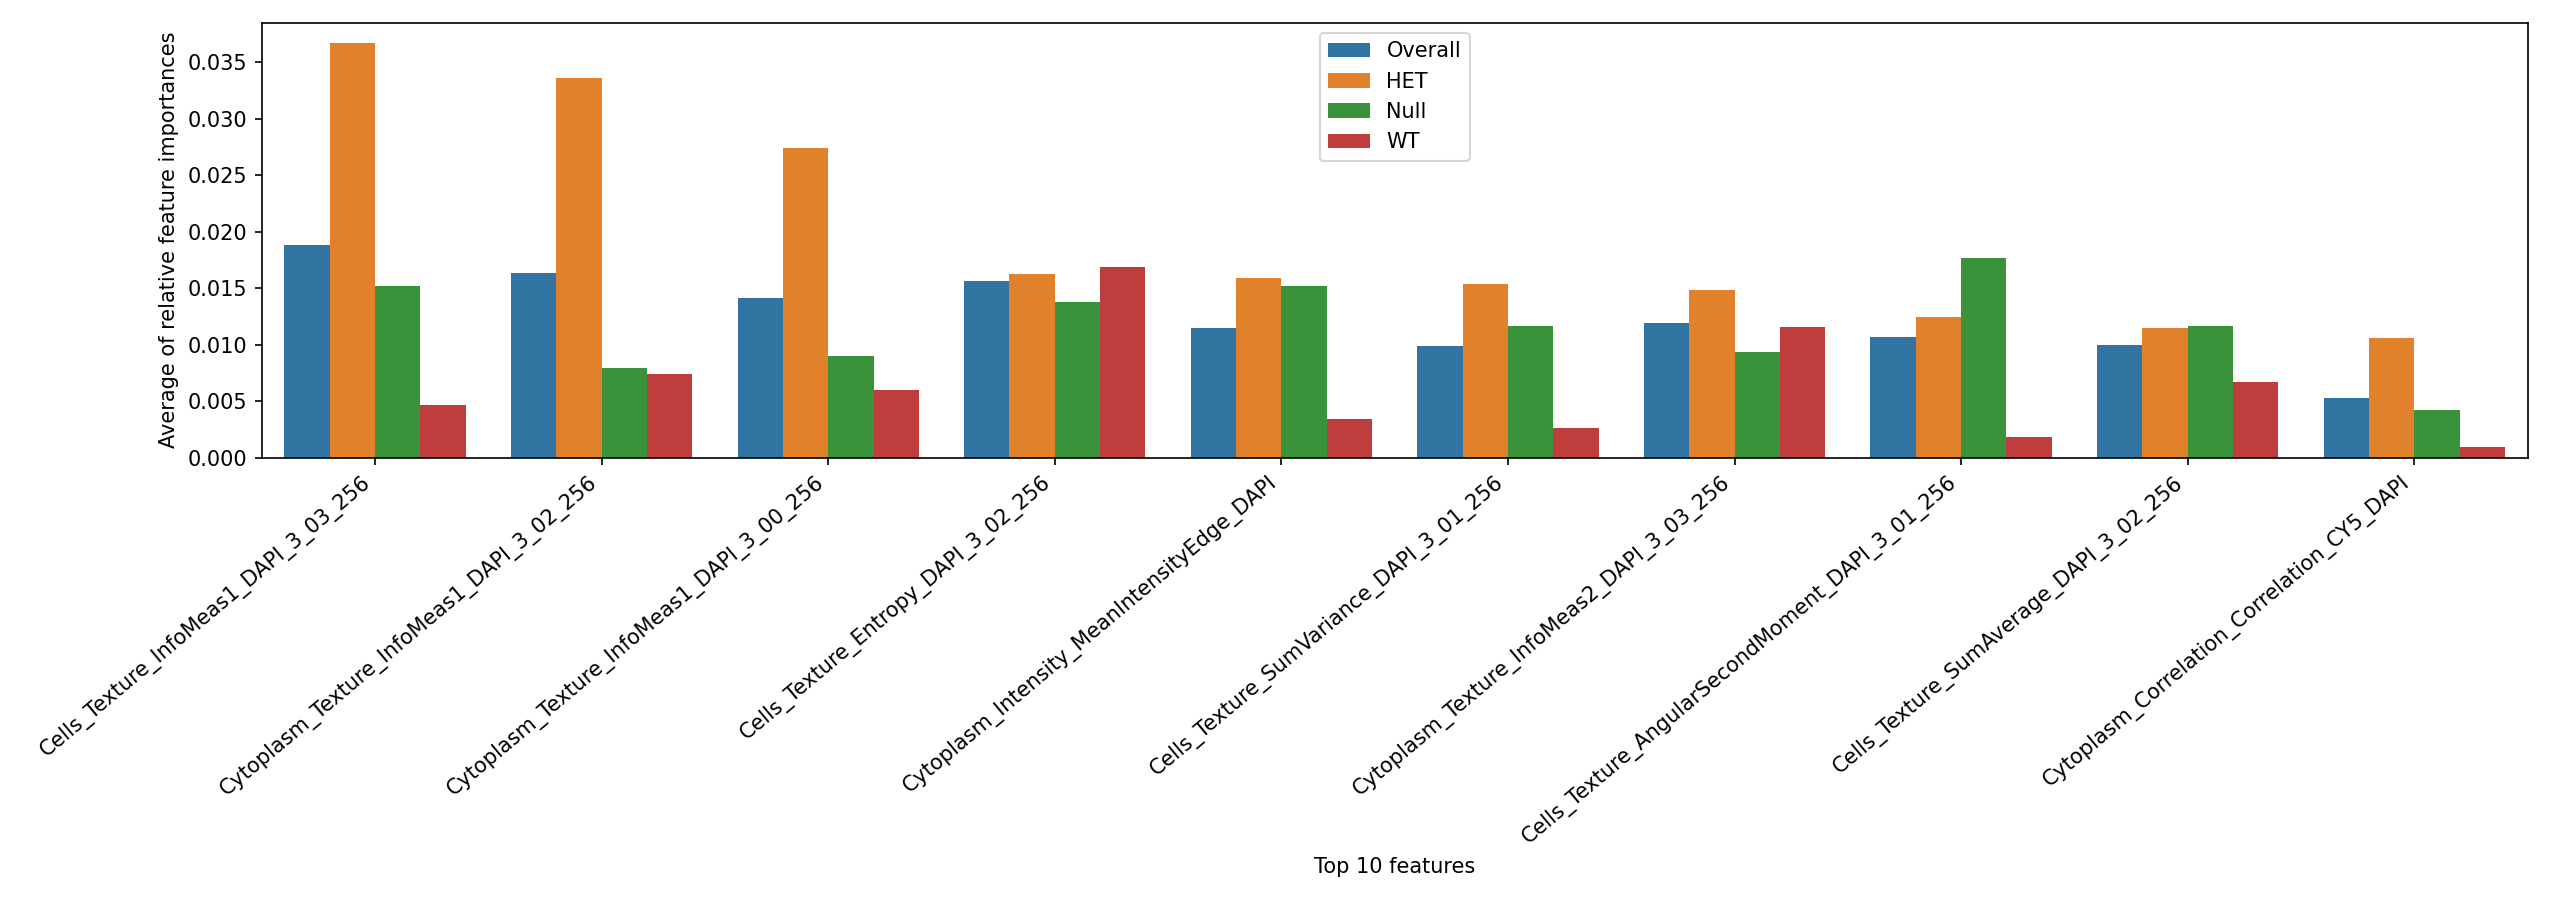

In [3]:
feat_imp = featimp[["Overall", "Features"]][:disp_feat]
feat_imp["category"] = ["Overall"] * disp_feat
col_names = featimp["Features"][:disp_feat]
feat_imp.rename(
    columns={"Features": "features", "Overall": "avg_importance"}, inplace=True
)

for genotype in pos_genes:
    tempdf = featimp.loc[featimp["Features"].isin(col_names)]
    tempdf = tempdf[[genotype, "Features"]]
    tempdf.rename(
        columns={genotype: "avg_importance", "Features": "features"}, inplace=True
    )
    tempdf["category"] = [genotype] * disp_feat
    feat_imp = pd.concat([feat_imp, tempdf], axis=0)

plt.figure(figsize=(17, 6))
ax = sns.barplot(
    x=feat_imp["features"], y=feat_imp["avg_importance"], hue=feat_imp["category"]
)
ax.set_xticklabels(col_names, rotation=40, ha="right")
plt.ylabel("Average of relative feature importances")
plt.xlabel("Top n features")
plt.xlabel(f"Top {disp_feat} features")
plt.tight_layout()
plt.legend(loc="upper center")
plt.savefig(f"{fig_out_path}/collective_average_feature_importances.png")